# CDCGAN

This notebook demonstrates the use of a Conditional Deep Convolutional GAN trained on the MNIST dataset.

## Install and Import packages

In [26]:
# %pip install numpy torch torchvision torch-summary Pillow ipython seaborn imageio

In [48]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import Video, display
from PIL import Image
from torchsummary import summary
from torchvision import datasets, transforms
from typing import Any, List, Optional, Union

Set fixed seed for reproducibility

In [49]:
seed = 1337
torch.manual_seed(seed)
np.random.seed(seed)

## Helper functions

In [50]:
def pt_to_numpy(images: torch.FloatTensor) -> np.ndarray:
    return images.detach().cpu().permute(0, 2, 3, 1).float().numpy()


def numpy_to_pt(images: np.ndarray) -> torch.FloatTensor:
    if images.ndim == 3:
        images = images[..., None]
    return torch.from_numpy(images.transpose(0, 3, 1, 2))


def numpy_to_pil(images: np.ndarray) -> Image.Image:
    if images.ndim == 3:
        images = images[None, ...]
    images = (images * 255).round().astype("uint8")
    if images.shape[-1] == 1:
        pil_images = [Image.fromarray(image.squeeze(), mode="L") for image in images]
    else:
        pil_images = [Image.fromarray(image) for image in images]
    return pil_images


def pil_to_numpy(images: Union[List[Image.Image], Image.Image]) -> np.ndarray:
    if not isinstance(images, Image.Image) and not isinstance(images, list):
        raise ValueError(
            f"Expected PIL image or list of PIL images, got {type(images)}."
        )
    if not isinstance(images, list):
        images = [images]
    images = [np.array(image).astype(np.float32) / 255.0 for image in images]
    images = np.stack(images, axis=0)
    return images


def normalize(images: torch.FloatTensor) -> torch.FloatTensor:
    return 2.0 * images - 1.0


def denormalize(images: torch.FloatTensor) -> torch.FloatTensor:
    return (0.5 + images / 2).clamp(0, 1)


def pil_to_video(images: List[Image.Image], filename: str, fps: int = 60) -> None:
    frames = [np.array(image) for image in images]
    with imageio.get_writer(filename, fps=fps) as video_writer:
        for frame in frames:
            video_writer.append_data(frame)


def image_grid(images: List[Image.Image], rows: int, cols: int) -> Image.Image:
    if len(images) > rows * cols:
        raise ValueError(
            f"Number of images ({len(images)}) exceeds grid size ({rows}x{cols})."
        )
    w, h = images[0].size
    grid = Image.new("L", size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid

### Load Dataset

Here, we load the MNIST dataset. We use a fixed subset of the dataset to speed up the training process since this is a simple demo. We convert the images to tensors and normalize values to the range [-1, 1].

In [51]:
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 32
subset_size = 8000

In [52]:
train_dataset = datasets.MNIST(
    root="data",
    train=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])]
    ),
    download=True,
)
train_dataset = torch.utils.data.Subset(train_dataset, range(subset_size))
dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

#### Visualize training dataset

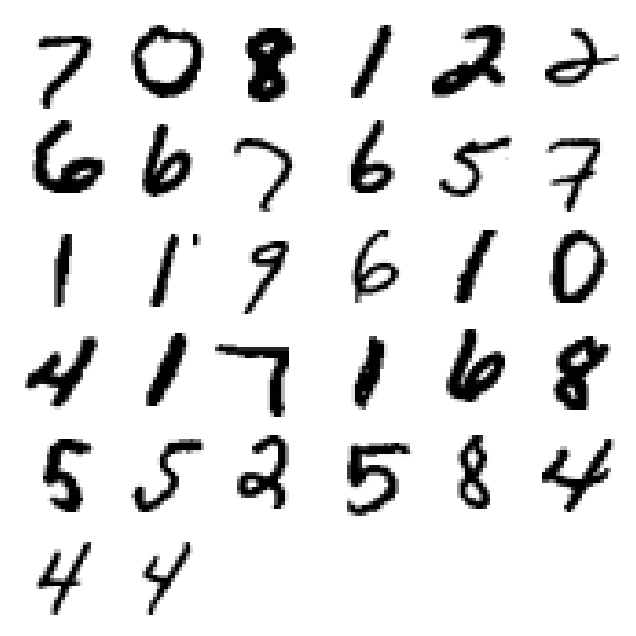

In [53]:
for batch_images, batch_labels in dataloader:
    rows = int(batch_size**0.5)
    if rows * rows < batch_size:
        rows += 1
    cols = rows
    batch_images = numpy_to_pil(pt_to_numpy(denormalize(batch_images)))
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(image_grid(batch_images, rows=rows, cols=cols), cmap="binary")
    plt.axis("off")
    plt.show()
    break

## Creating Models

We define the Generator and Discriminator - components of a GAN.

In [54]:
class Generator(nn.Module):
    def __init__(
        self,
        num_embeddings: int,
        latent_channels: int,
        output_channels: int,
        channels: List[int],
        device: str = "cuda",
    ) -> None:
        super().__init__()

        self.num_embeddings = num_embeddings
        self.latent_channels = latent_channels
        self.output_channels = output_channels
        self.channels = channels
        self.device = device

        if len(channels) != 4:
            raise ValueError(
                f"`channels` should have length 4 as this model uses 4 ConvTranspose2d layers with configurable out_channels"
            )

        def block(
            in_channels: int,
            out_channels: int,
            kernel_size: int,
            strides: int,
            padding: int,
        ) -> nn.Sequential:
            return nn.Sequential(
                nn.ConvTranspose2d(
                    in_channels, out_channels, kernel_size, strides, padding
                ),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.25, inplace=True),
            )

        self.label_pass = block(num_embeddings, channels[0] // 2, 4, 2, 1)
        self.latent_pass = block(latent_channels, channels[0] // 2, 4, 2, 1)

        self.model = nn.Sequential()
        self.model.append(block(channels[0], channels[1], 4, 2, 1))
        self.model.append(block(channels[1], channels[2], 4, 1, 0))
        self.model.append(block(channels[2], channels[3], 4, 2, 1))
        self.model.append(nn.ConvTranspose2d(channels[3], output_channels, 4, 2, 1))
        self.model.append(nn.Tanh())

        self.to(device)

    def forward(
        self, latent: torch.FloatTensor, labels: torch.FloatTensor
    ) -> torch.FloatTensor:
        latent = latent.to(self.device)
        labels = labels.to(self.device)

        latent = latent.view(-1, self.latent_channels, 1, 1)
        labels = labels.view(-1, self.num_embeddings, 1, 1)

        latent = self.latent_pass(latent)
        labels = self.label_pass(labels)

        x = torch.cat([latent, labels], dim=1)
        x = self.model(x)

        return x.view(-1, 28, 28)

In [55]:
class Discriminator(nn.Module):
    def __init__(
        self,
        num_embeddings: int,
        input_channels: int,
        output_channels: int,
        channels: List[int],
        device: str = "cuda",
    ) -> None:
        super().__init__()

        self.num_embeddings = num_embeddings
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.channels = channels
        self.device = device

        if len(channels) != 4:
            raise ValueError(
                f"`channels` should have length 4 as this model uses 4 ConvTranspose2d layers with configurable out_channels"
            )

        def block(
            in_channels: int,
            out_channels: int,
            kernel_size: int,
            strides: int,
            padding: int,
        ) -> nn.Sequential:
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.25, inplace=True),
            )

        self.embedding_pass = block(num_embeddings, channels[0] // 2, 4, 2, 1)
        self.image_pass = block(input_channels, channels[0] // 2, 4, 2, 1)

        self.model = nn.Sequential()
        self.model.append(block(channels[0], channels[1], 4, 2, 1))
        self.model.append(block(channels[1], channels[2], 4, 1, 0))
        self.model.append(block(channels[2], channels[3], 4, 2, 1))
        self.model.append(nn.Conv2d(channels[3], output_channels, 4, 2, 1))
        self.model.append(nn.Sigmoid())

        self.to(device)

    def forward(
        self, images: torch.FloatTensor, labels: torch.FloatTensor
    ) -> torch.FloatTensor:
        images = images.to(self.device)
        labels = labels.to(self.device)

        images = images.view(-1, 1, 28, 28)

        images = self.image_pass(images)
        embedding = self.embedding_pass(labels)

        x = torch.cat([images, embedding], dim=1)
        x = self.model(x)

        return x.squeeze()

#### Configure Hyperparameters for Training

In [56]:
epochs = 20
learning_rate_g = 1e-4
learning_rate_d = 1e-4
steps_g = 1
steps_d = 2
num_embeddings = 10  # 10 classes in MNIST
latent_channels = 128
log_steps = 100

generator_hidden_channels = [256, 256, 128, 64]
discriminator_hidden_channels = [64, 128, 256, 256]

In [57]:
generator = Generator(
    num_embeddings=num_embeddings,
    latent_channels=latent_channels,
    output_channels=1,
    channels=generator_hidden_channels,
    device=device,
)
discriminator = Discriminator(
    num_embeddings=num_embeddings,
    input_channels=1,
    output_channels=1,
    channels=discriminator_hidden_channels,
    device=device,
)

In [58]:
_ = summary(
    generator,
    [(1, latent_channels), (num_embeddings,)],
    dtypes=[torch.FloatTensor, torch.FloatTensor],
    device=device,
)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 2, 2]           --
|    └─ConvTranspose2d: 2-1              [-1, 128, 2, 2]           262,272
|    └─BatchNorm2d: 2-2                  [-1, 128, 2, 2]           256
|    └─LeakyReLU: 2-3                    [-1, 128, 2, 2]           --
├─Sequential: 1-2                        [-1, 128, 2, 2]           --
|    └─ConvTranspose2d: 2-4              [-1, 128, 2, 2]           20,608
|    └─BatchNorm2d: 2-5                  [-1, 128, 2, 2]           256
|    └─LeakyReLU: 2-6                    [-1, 128, 2, 2]           --
├─Sequential: 1-3                        [-1, 1, 28, 28]           --
|    └─Sequential: 2-7                   [-1, 256, 4, 4]           --
|    |    └─ConvTranspose2d: 3-1         [-1, 256, 4, 4]           1,048,832
|    |    └─BatchNorm2d: 3-2             [-1, 256, 4, 4]           512
|    |    └─LeakyReLU: 3-3               [-1, 256, 4, 4]          

In [59]:
_ = summary(
    discriminator,
    [(1, 28, 28), (10, 28, 28)],
    dtypes=[torch.FloatTensor, torch.FloatTensor],
    device=device,
)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 14, 14]          --
|    └─Conv2d: 2-1                       [-1, 32, 14, 14]          544
|    └─BatchNorm2d: 2-2                  [-1, 32, 14, 14]          64
|    └─LeakyReLU: 2-3                    [-1, 32, 14, 14]          --
├─Sequential: 1-2                        [-1, 32, 14, 14]          --
|    └─Conv2d: 2-4                       [-1, 32, 14, 14]          5,152
|    └─BatchNorm2d: 2-5                  [-1, 32, 14, 14]          64
|    └─LeakyReLU: 2-6                    [-1, 32, 14, 14]          --
├─Sequential: 1-3                        [-1, 1, 1, 1]             --
|    └─Sequential: 2-7                   [-1, 128, 7, 7]           --
|    |    └─Conv2d: 3-1                  [-1, 128, 7, 7]           131,200
|    |    └─BatchNorm2d: 3-2             [-1, 128, 7, 7]           256
|    |    └─LeakyReLU: 3-3               [-1, 128, 7, 7]           --
|    

## Training

In [60]:
loss = nn.BCELoss()
optim_g = torch.optim.Adam(
    generator.parameters(), lr=learning_rate_g, betas=(0.5, 0.999)
)
optim_d = torch.optim.Adam(
    discriminator.parameters(), lr=learning_rate_d, betas=(0.5, 0.999)
)

In [61]:
onehot = F.one_hot(torch.arange(num_embeddings)).type(torch.FloatTensor)
embeddings = torch.zeros([num_embeddings, num_embeddings, 28, 28]).type(
    torch.FloatTensor
)
for i in range(num_embeddings):
    embeddings[i, i, :, :] = 1

In [62]:
def trainstep_g():
    optim_g.zero_grad()

    latent = torch.randn((batch_size, latent_channels))
    fake_labels = torch.randint(0, num_embeddings, (batch_size,))
    fake_images = generator(latent, onehot[fake_labels])

    validity = discriminator(fake_images, embeddings[fake_labels])
    fake_loss = loss(validity, torch.ones(batch_size, device=device))

    fake_loss.backward()
    optim_g.step()

    return fake_loss

In [63]:
def trainstep_d(images, labels):
    optim_d.zero_grad()

    # We can't use the global batch_size because dataloader may have truncation
    # for last uncomplete batch
    batch_size = images.shape[0]

    real_validity = discriminator(images, embeddings[labels])
    real_loss = loss(real_validity, torch.ones(batch_size, device=device))

    latent = torch.randn((batch_size, latent_channels))
    fake_labels = torch.randint(0, num_embeddings, (batch_size,))
    fake_images = generator(latent, onehot[fake_labels])

    fake_validity = discriminator(fake_images, embeddings[fake_labels])
    fake_loss = loss(fake_validity, torch.zeros(batch_size, device=device))

    discriminator_loss = (real_loss + fake_loss) / 2

    discriminator_loss.backward()
    optim_d.step()

    return discriminator_loss

In [64]:
grid_images = []
generator_losses = []
discriminator_losses = []

In [65]:
def train(epochs: int):
    steps = 0
    generator.train()
    discriminator.train()

    for epoch in range(epochs):
        generator.train()

        for index, (images, labels) in enumerate(dataloader):
            generator_loss = 0
            discriminator_loss = 0

            for _ in range(steps_g):
                generator_loss += trainstep_g().mean().item()
            for _ in range(steps_d):
                discriminator_loss += trainstep_d(images, labels).mean().item()

            generator_losses.append(generator_loss / steps_g)
            discriminator_losses.append(discriminator_loss / steps_d)

            if steps % log_steps == 0:
                print(
                    f"Epoch: {epoch}, Generator loss: {generator_loss:.4f}, Discriminator loss: {discriminator_loss:.4f}"
                )
            steps += 1

        print(
            f"Epoch: {epoch}, Generator loss: {generator_loss:.4f}, Discriminator loss: {discriminator_loss:.4f}"
        )
        print("-" * 64)

        grid_image = visualize()
        grid_images.append(grid_image)

        if epoch % 4 == 0:
            fig = plt.figure(figsize=(8, 8))
            plt.imshow(grid_image, cmap="binary")
            plt.axis("off")
            plt.show()


def visualize():
    labels = onehot[torch.arange(0, 10).unsqueeze(dim=-1).repeat(1, 10)]

    with torch.no_grad():
        generator.eval()

        latents = torch.randn((100, latent_channels))
        sampled_images = generator(latents, labels).unsqueeze(dim=1)
        sampled_images = numpy_to_pil(pt_to_numpy(denormalize(sampled_images)))
        grid_image = image_grid(sampled_images, rows=10, cols=10)

    return grid_image

Epoch: 0, Generator loss: 0.6696, Discriminator loss: 1.3715
Epoch: 0, Generator loss: 5.8749, Discriminator loss: 0.0135
Epoch: 0, Generator loss: 5.0412, Discriminator loss: 0.0739
Epoch: 0, Generator loss: 4.0276, Discriminator loss: 0.6333
----------------------------------------------------------------


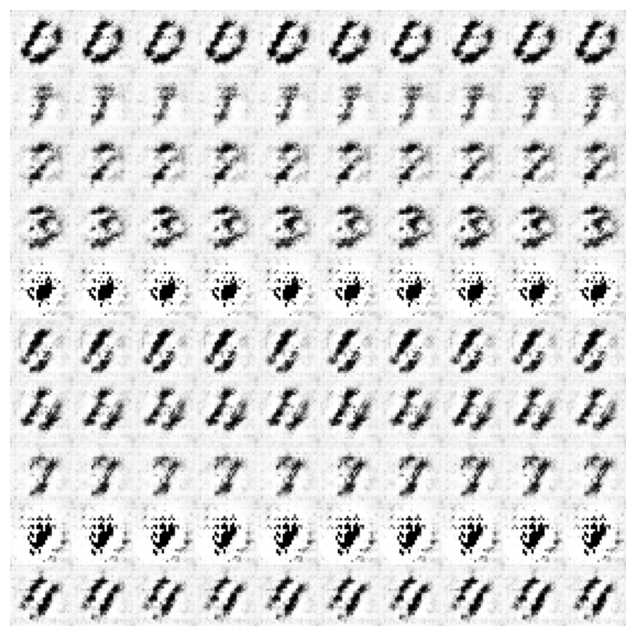

Epoch: 1, Generator loss: 2.9275, Discriminator loss: 0.1450
Epoch: 1, Generator loss: 3.3332, Discriminator loss: 0.3424
Epoch: 1, Generator loss: 5.6385, Discriminator loss: 0.0080
----------------------------------------------------------------
Epoch: 2, Generator loss: 6.2582, Discriminator loss: 0.0126
Epoch: 2, Generator loss: 4.7489, Discriminator loss: 0.4760
Epoch: 2, Generator loss: 4.0927, Discriminator loss: 0.3992
Epoch: 2, Generator loss: 4.4413, Discriminator loss: 0.5076
----------------------------------------------------------------
Epoch: 3, Generator loss: 3.7882, Discriminator loss: 0.7263
Epoch: 3, Generator loss: 5.5765, Discriminator loss: 0.1575
Epoch: 3, Generator loss: 6.5942, Discriminator loss: 0.1384
----------------------------------------------------------------
Epoch: 4, Generator loss: 5.1009, Discriminator loss: 0.1567
Epoch: 4, Generator loss: 4.5940, Discriminator loss: 0.2843
Epoch: 4, Generator loss: 6.5068, Discriminator loss: 0.0869
Epoch: 4, Ge

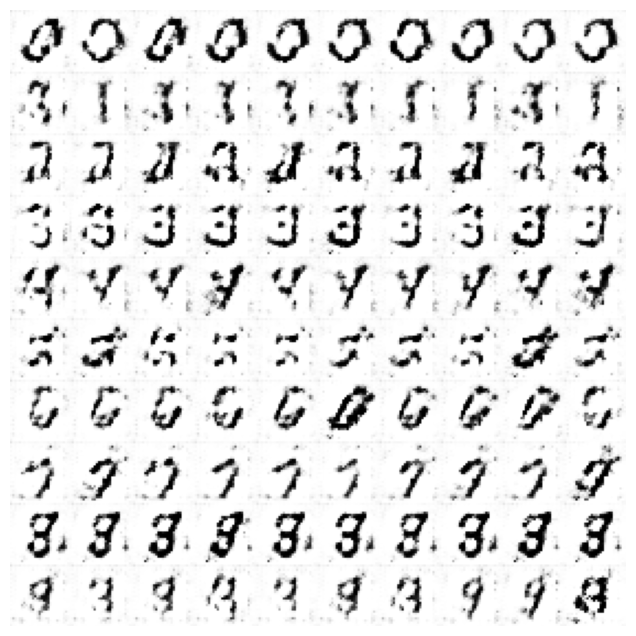

Epoch: 5, Generator loss: 5.3080, Discriminator loss: 0.2327
Epoch: 5, Generator loss: 5.4253, Discriminator loss: 0.5138
Epoch: 5, Generator loss: 5.5026, Discriminator loss: 0.0628
----------------------------------------------------------------
Epoch: 6, Generator loss: 2.4036, Discriminator loss: 0.2040
Epoch: 6, Generator loss: 7.7196, Discriminator loss: 0.3890
Epoch: 6, Generator loss: 3.7429, Discriminator loss: 0.1574
Epoch: 6, Generator loss: 4.9596, Discriminator loss: 0.0324
----------------------------------------------------------------
Epoch: 7, Generator loss: 4.8976, Discriminator loss: 0.6210
Epoch: 7, Generator loss: 4.3768, Discriminator loss: 0.0916
Epoch: 7, Generator loss: 2.7954, Discriminator loss: 0.1521
----------------------------------------------------------------
Epoch: 8, Generator loss: 3.7042, Discriminator loss: 0.2412
Epoch: 8, Generator loss: 5.3453, Discriminator loss: 0.2227
Epoch: 8, Generator loss: 3.1939, Discriminator loss: 0.3003
Epoch: 8, Ge

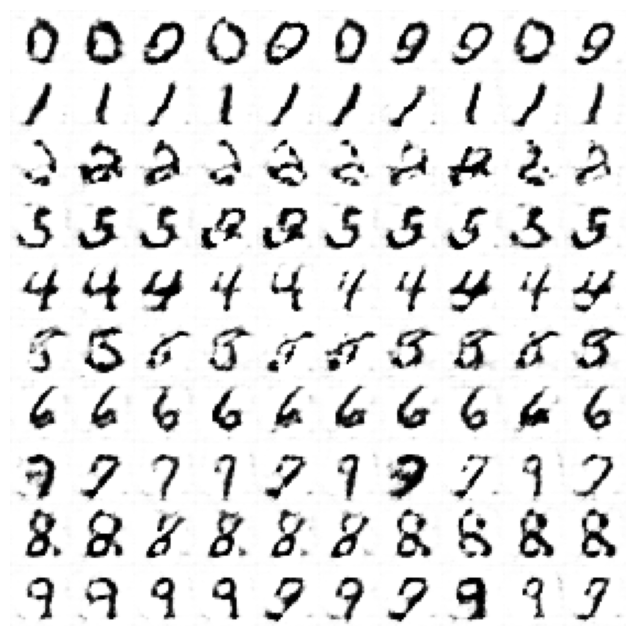

Epoch: 9, Generator loss: 5.3961, Discriminator loss: 0.2162
Epoch: 9, Generator loss: 0.9143, Discriminator loss: 0.1728
Epoch: 9, Generator loss: 5.6406, Discriminator loss: 0.0843
----------------------------------------------------------------
Epoch: 10, Generator loss: 4.1716, Discriminator loss: 0.1387
Epoch: 10, Generator loss: 7.1320, Discriminator loss: 0.0518
Epoch: 10, Generator loss: 4.4918, Discriminator loss: 0.2403
Epoch: 10, Generator loss: 6.2432, Discriminator loss: 0.3077
----------------------------------------------------------------
Epoch: 11, Generator loss: 1.9746, Discriminator loss: 0.8362
Epoch: 11, Generator loss: 3.3492, Discriminator loss: 0.0792
Epoch: 11, Generator loss: 3.2105, Discriminator loss: 0.8698
----------------------------------------------------------------
Epoch: 12, Generator loss: 7.6248, Discriminator loss: 1.4209
Epoch: 12, Generator loss: 2.8146, Discriminator loss: 0.4247
Epoch: 12, Generator loss: 3.5390, Discriminator loss: 0.3338
Ep

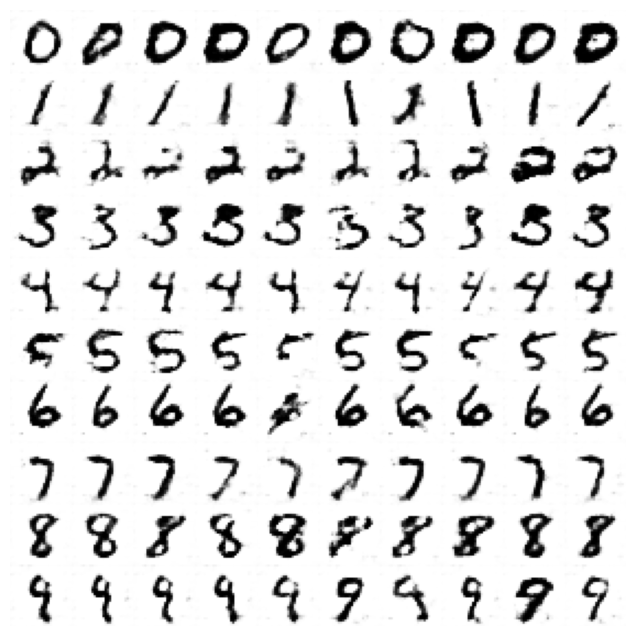

Epoch: 13, Generator loss: 2.4604, Discriminator loss: 0.6785
Epoch: 13, Generator loss: 5.0018, Discriminator loss: 0.3717
Epoch: 13, Generator loss: 2.1609, Discriminator loss: 0.1957
----------------------------------------------------------------
Epoch: 14, Generator loss: 5.4543, Discriminator loss: 0.1218
Epoch: 14, Generator loss: 3.2125, Discriminator loss: 0.4804
Epoch: 14, Generator loss: 5.3704, Discriminator loss: 0.1094
Epoch: 14, Generator loss: 2.9720, Discriminator loss: 0.1688
----------------------------------------------------------------
Epoch: 15, Generator loss: 3.6937, Discriminator loss: 0.8561
Epoch: 15, Generator loss: 5.6069, Discriminator loss: 0.1147
Epoch: 15, Generator loss: 4.6029, Discriminator loss: 0.5187
----------------------------------------------------------------
Epoch: 16, Generator loss: 6.0157, Discriminator loss: 0.2587
Epoch: 16, Generator loss: 4.1487, Discriminator loss: 0.1279
Epoch: 16, Generator loss: 4.8165, Discriminator loss: 0.0632

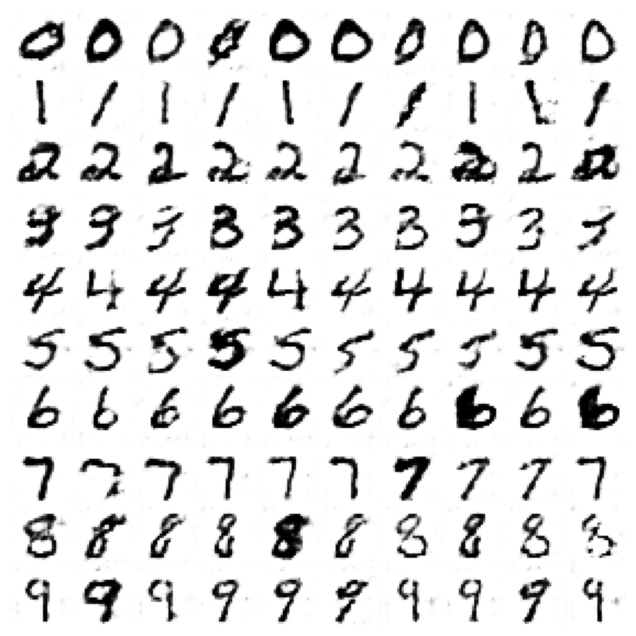

Epoch: 17, Generator loss: 3.2569, Discriminator loss: 0.0403
Epoch: 17, Generator loss: 3.6269, Discriminator loss: 0.3447
Epoch: 17, Generator loss: 1.3514, Discriminator loss: 0.2852
----------------------------------------------------------------
Epoch: 18, Generator loss: 3.4617, Discriminator loss: 0.1152
Epoch: 18, Generator loss: 5.8063, Discriminator loss: 0.1582
Epoch: 18, Generator loss: 5.5938, Discriminator loss: 0.0952
Epoch: 18, Generator loss: 3.7839, Discriminator loss: 0.2564
----------------------------------------------------------------
Epoch: 19, Generator loss: 4.8350, Discriminator loss: 0.1866
Epoch: 19, Generator loss: 2.3312, Discriminator loss: 0.6637
Epoch: 19, Generator loss: 5.3820, Discriminator loss: 0.1231
----------------------------------------------------------------


In [66]:
train(epochs)

## Visualization

In [67]:
filename = "cdcgan_generation_over_time.mp4"
pil_to_video(grid_images, filename, fps=6)

In [68]:
display(Video(filename, embed=True))

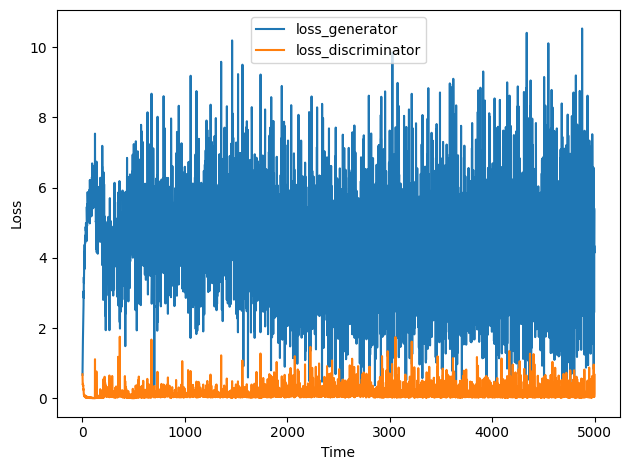

In [69]:
plt.plot(generator_losses, label="loss_generator")
plt.plot(discriminator_losses, label="loss_discriminator")
plt.xlabel("Time")
plt.ylabel("Loss")
plt.tight_layout()
plt.legend()
plt.show()

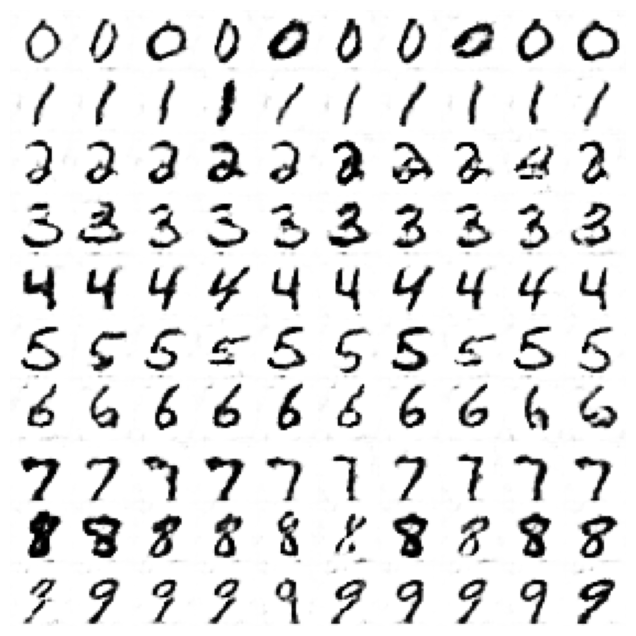

In [70]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(visualize(), cmap="binary")
plt.axis("off")
plt.show()